### Business Problem

#### Description

- Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

- Currently, Quora uses a Random Forest model to identify duplicate questions. Our goal is to tackle this natural language processing problem by applying advanced techniques to classify whether question pairs are duplicates or not. Doing so will make it easier to find high quality answers to questions resulting in an improved experience for Quora writers, seekers, and readers.

[source - Kaggle](https://www.kaggle.com/c/quora-question-pairs)

#### Problem Statement
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

### Reading data

In [4]:
data = pd.read_csv('../data/train.csv')

In [5]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### Data fields

- id - the id of a training set question pair
- qid1, qid2 - unique ids of each question (only available in train.csv)
- question1, question2 - the full text of each question
- is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

#### Type of problem
- This is binary classification problem.

#### Performance metrics:
(Source: https://www.kaggle.com/c/quora-question-pairs#evaluation)
- Log-loss.
- Binary confusion matrix.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB




Let's see the class distribution of our target variable.



In [21]:
print("No of duplicate pair instances in the data {}%".format(round(len(data[data['is_duplicate'] == 1]) / len(data) *100)))
print("No of non-duplicate pair instances in the data {}%".format(round(len(data[data['is_duplicate'] == 0])/len(data) * 100)))

No of duplicate pair instances in the data 37%
No of non-duplicate pair instances in the data 63%


<AxesSubplot:xlabel='is_duplicate', ylabel='count'>

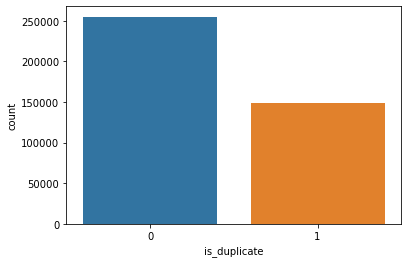

In [14]:
import seaborn as sns

sns.countplot(data = data, x = 'is_duplicate')

### Number of unique questions.

In [26]:
question_ids = list(list(data['qid1'].unique()) + list(data['qid2'].unique()))

In [85]:
print("Total number of unique questions present in the dataset {}".format(len(set(question_ids))))
qids = pd.Series(list(data['qid1'])+list(data['qid2']))
print("Number of unique questions repeated more than once {}".format(sum(qids.value_counts() > 1)))
print("Max times a single question is repeated {}".format(max(qids.value_counts())))

Total number of unique questions present in the dataset 537933
Number of unique questions repeated more than once 111780
Max times a single question is repeated 157


### Checking for duplicates

In [87]:
pair_duplicates = data[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - data.shape[0])

Number of duplicate questions 0


### Checking for null values

In [94]:
data[data.isna().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [97]:
data = data.fillna(' ')

In [98]:
data[data.isna().any(1)]

,id,qid1,qid2,question1,question2,is_duplicate


In [99]:
data.groupby('qid1')['qid1'].transform('count')

0          1
1          4
2          1
3          1
4          3
          ..
404285     2
404286    12
404287     1
404288     1
404289     1
Name: qid1, Length: 404290, dtype: int64

In [100]:
data.groupby('qid1')['qid1'].tranform('count')

qid1
1         1
3         4
4         1
5         1
7         1
         ..
537924    1
537926    1
537928    1
537930    1
537932    1
Name: qid1, Length: 290654, dtype: int64

In [127]:
data['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count') 
data['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')
data['q1len'] = data['question1'].str.len() 
data['q2len'] = data['question2'].str.len()
data['q1_n_words'] = data['question1'].apply(lambda row: len(row.split(" ")))
data['q2_n_words'] = data['question2'].apply(lambda row: len(row.split(" ")))


def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)
data['word_Common'] = data.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
data['word_Total'] = data.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
data['word_share'] = data.apply(normalized_word_share, axis=1)

data['freq_q1+q2'] = data['freq_qid1']+data['freq_qid2']
data['freq_q1-q2'] = abs(data['freq_qid1']-data['freq_qid2'])

data.to_csv("df_fe_without_preprocessing_train.csv", index=False)

In [128]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [129]:
data.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

In [130]:
len({"abc", "def", "skf"} & {"ghi", "def", "skf"})

2

In [131]:
print ("Shortest question in question1 is of length " , min(data['q1_n_words']))

print ("Shortest question in question2 is of length " , min(data['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", data[data['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", data[data['q2_n_words']== 1].shape[0])

Shortest question in question1 is of length  1
Shortest question in question2 is of length  1
Number of Questions with minimum length [question1] : 66
Number of Questions with minimum length [question2] : 22


/Users/nikhilkarve/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nikhilkarve/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


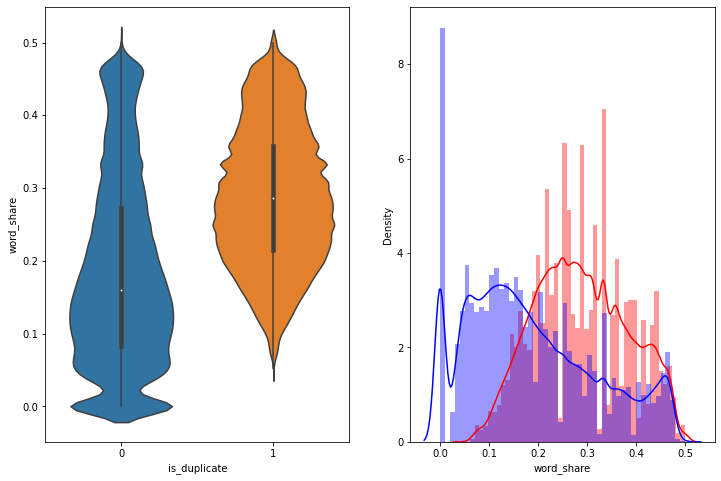

In [138]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = data[0:])

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['word_share'][0:],label='1', color='red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_share'][0:],label='0', color='blue')

plt.show()

- The distributions for normalized word_share have some overlap as value of word_share increases, i.e., there are quite a lot of questions with high word similarity.
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

/Users/nikhilkarve/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/nikhilkarve/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


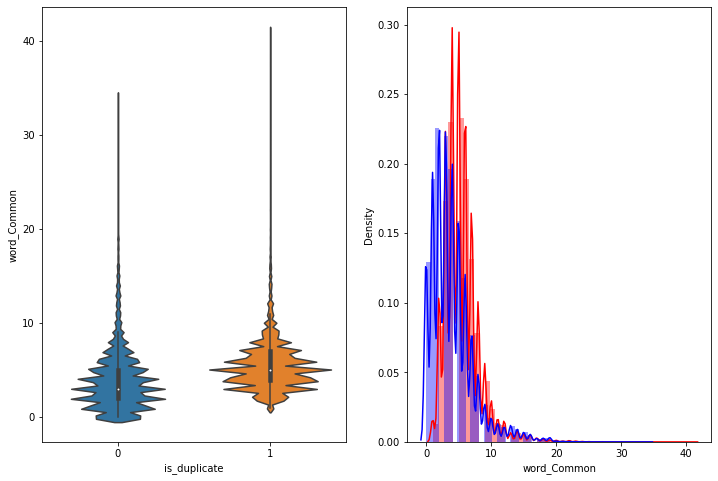

In [139]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = data[0:])

plt.subplot(1,2,2)
sns.distplot(data[data['is_duplicate'] == 1.0]['word_Common'][0:],label='1', color='red')
sns.distplot(data[data['is_duplicate'] == 0.0]['word_Common'][0:],label='0', color='blue')

plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping. Hence can not be considered as a good feature compared to word_share </p>